<a href="https://colab.research.google.com/github/heet25itachi/TIMEPASS_BUDDY/blob/physics/Rocket%20Launch%20Simulation%20%26%20Instantaneous%20Acceleration%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Rocket Launch Model Initialized ---
Engine Burn Time: 209.60 seconds
Simulating 214.6 seconds of flight...

----------------------------------------------------------------------
ANALYSIS AT TIME t₀ = 10.00 s
TRUE INSTANTANEOUS ACCELERATION (dv/dt): 4.6827 m/s²
----------------------------------------------------------------------
| Δt (s)       | Δv (m/s)     | Avg. Accel (m/s²)    | Difference from True |
|-------------|--------------|----------------------|----------------------|
| 0.500        | 2.3496       | 4.6991               | 0.016371             |
| 0.100        | 0.4686       | 4.6857               | 0.003005             |
| 0.050        | 0.2342       | 4.6841               | 0.001335             |
| 0.010        | 0.0468       | 4.6827               | 0.000000             |
| 0.005        | 0.0468       | 9.3655               | 4.682734             |

Observation: As Δt approaches zero, the Average Acceleration (Δv/Δt) converges to the True Instantaneous Acceleration

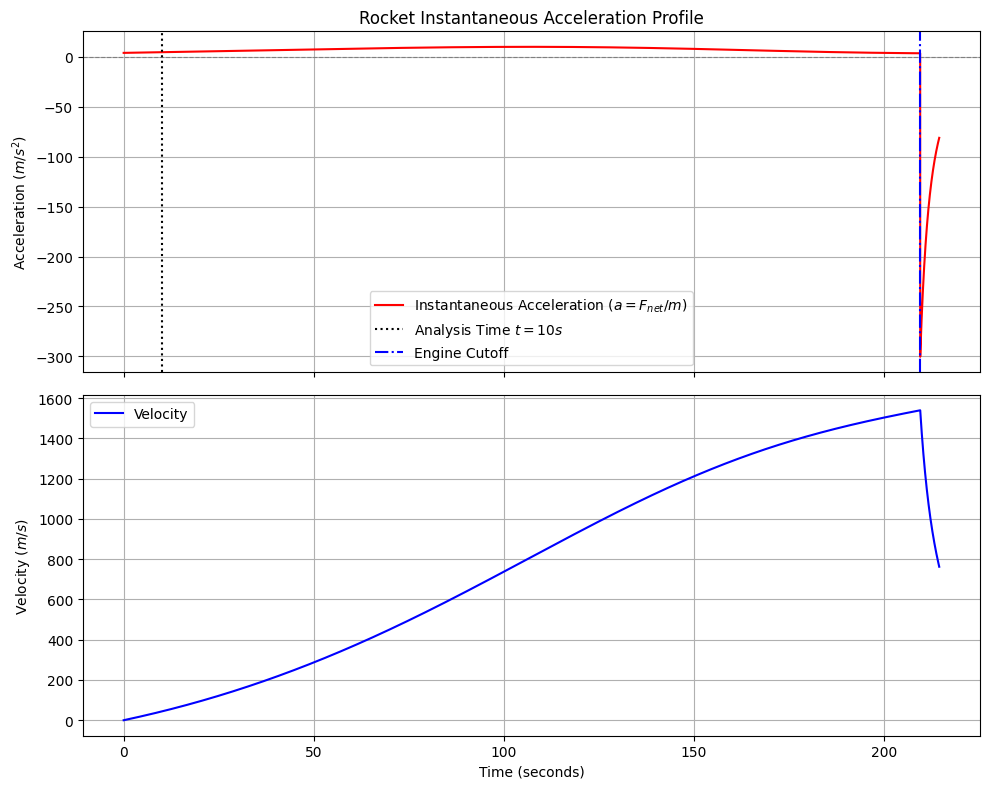

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# 1. ROCKET PHYSICS MODEL
# =============================================================================

class RocketModel:
    """
    Simulates a vertically launched rocket with changing mass and air drag.
    This class is the foundation for calculating instantaneous acceleration.
    """
    G = 9.81           # Acceleration due to gravity (m/s^2)

    def __init__(self):
        # --- Rocket Initial Parameters (Falcon 9 approximations) ---
        self.initial_mass = 549000.0  # Initial mass (kg, propellants + structure)
        self.struct_mass = 25000.0    # Mass of the rocket structure (kg)
        self.thrust = 7600000.0       # Engine thrust (Newtons)
        self.burn_rate = 2500.0       # Mass burned per second (kg/s)
        self.engine_on_time = (self.initial_mass - self.struct_mass) / self.burn_rate

        # --- Drag Parameters ---
        self.drag_coeff = 0.5         # Drag coefficient
        self.reference_area = 10.0    # Cross-sectional area (m^2)
        self.rho = 1.225              # Air density (kg/m^3, constant for simplicity)

    def get_mass(self, t):
        """Calculates the instantaneous mass m(t)."""
        if t < 0:
            return self.initial_mass
        if t >= self.engine_on_time:
            return self.struct_mass

        # Mass decreases linearly as fuel burns
        return self.initial_mass - (self.burn_rate * t)

    def get_thrust(self, t):
        """Thrust is zero after engine cutoff."""
        return self.thrust if t < self.engine_on_time else 0.0

    def get_drag_force(self, v):
        """Calculates the instantaneous air drag force (proportional to v^2)."""
        # F_drag = 0.5 * rho * v^2 * C_d * A
        return 0.5 * self.rho * v**2 * self.drag_coeff * self.reference_area

    def get_acceleration(self, t, v):
        """
        Calculates the instantaneous acceleration a = dv/dt at time t,
        based on the net force F_net / mass.
        """
        mass = self.get_mass(t)
        thrust = self.get_thrust(t)
        drag = self.get_drag_force(v)
        gravity = mass * self.G

        # F_net = Thrust - Gravity - Drag (Drag is always opposite to velocity)
        F_net = thrust - gravity - drag

        # Instantaneous Acceleration: a(t) = F_net / m(t)
        a_instantaneous = F_net / mass

        return a_instantaneous

# =============================================================================
# 2. SIMULATION (EULER INTEGRATION)
# =============================================================================

def simulate_motion(model, total_time, dt=0.01):
    """
    Runs the simulation using Euler integration (the practical limit approximation).
    """
    times = np.arange(0, total_time + dt, dt)
    history = {
        't': [], 'v': [], 'h': [], 'a_inst': []
    }

    # Initial conditions
    v = 0.0  # Initial velocity
    h = 0.0  # Initial height

    for t in times:
        a_inst = model.get_acceleration(t, v)

        # Record state
        history['t'].append(t)
        history['v'].append(v)
        history['h'].append(h)
        history['a_inst'].append(a_inst)

        # Euler step: v(t+dt) = v(t) + a * dt
        v += a_inst * dt
        h += v * dt  # h(t+dt) = h(t) + v * dt

        # Stop if velocity becomes negative (after engine cut-off)
        if v < 0 and t > model.engine_on_time:
             break

    return history

# =============================================================================
# 3. ANALYSIS: DEMONSTRATING THE LIMIT (a = lim Δt→0 Δv/Δt)
# =============================================================================

def analyze_acceleration(model, history, analysis_time=10.0):
    """
    Explicitly demonstrates the limit definition by comparing instantaneous
    acceleration with average acceleration over decreasing time windows (Δt).
    """
    # 1. Find the index corresponding to the analysis time (t=10.0s)
    time_array = np.array(history['t'])
    index_t = np.argmin(np.abs(time_array - analysis_time))

    t0 = history['t'][index_t]
    v0 = history['v'][index_t]

    # Calculate the true instantaneous acceleration at t0 (the target value)
    a_true = model.get_acceleration(t0, v0)

    print("-" * 70)
    print(f"ANALYSIS AT TIME t₀ = {t0:.2f} s")
    print(f"TRUE INSTANTANEOUS ACCELERATION (dv/dt): {a_true:.4f} m/s²")
    print("-" * 70)

    results = []
    # Test different time steps Δt (making Δt smaller simulates the limit)
    delta_t_tests = [0.5, 0.1, 0.05, 0.01, 0.005]

    for delta_t in delta_t_tests:
        # Find the state at t_final = t0 + delta_t
        t_final = t0 + delta_t

        # We need to find the velocity v_final corresponding to t_final
        index_final = np.argmin(np.abs(time_array - t_final))
        if index_final >= len(history['v']):
            continue # Skip if out of bounds

        v_final = history['v'][index_final]

        # Calculate Average Acceleration: a_avg = Δv / Δt
        delta_v = v_final - v0

        a_avg = delta_v / delta_t
        difference = a_avg - a_true

        results.append({
            "Delta t (s)": f"{delta_t:.3f}",
            "Delta v (m/s)": f"{delta_v:.4f}",
            "Avg. Accel (m/s²)": f"{a_avg:.4f}",
            "Difference": f"{difference:.6f}"
        })

    # Print results table
    print(f"| {'Δt (s)':<12} | {'Δv (m/s)':<12} | {'Avg. Accel (m/s²)' :<20} | {'Difference from True':<20} |")
    print(f"|{'-'*13}|{'-'*14}|{'-'*22}|{'-'*22}|")
    for r in results:
        print(f"| {r['Delta t (s)']:<12} | {r['Delta v (m/s)']:<12} | {r['Avg. Accel (m/s²)'] :<20} | {r['Difference']:<20} |")

    print("\nObservation: As Δt approaches zero, the Average Acceleration (Δv/Δt) converges to the True Instantaneous Acceleration (dv/dt).")

# =============================================================================
# 4. MAIN EXECUTION AND PLOTTING
# =============================================================================

def run_analysis():
    """Initializes the model, runs the simulation, and performs the analysis."""

    # 1. Initialize Model
    rocket = RocketModel()
    total_time = rocket.engine_on_time + 5 # 5 seconds past engine cutoff

    print("--- Rocket Launch Model Initialized ---")
    print(f"Engine Burn Time: {rocket.engine_on_time:.2f} seconds")
    print(f"Simulating {total_time:.1f} seconds of flight...\n")

    # 2. Run Simulation
    # The simulation uses a very small dt (0.01s) to approximate the instantaneous process
    history = simulate_motion(rocket, total_time, dt=0.01)

    # 3. Analyze the Limit Definition (The core request)
    analyze_acceleration(rocket, history, analysis_time=10.0)

    # 4. Plot Results for Depth
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot 1: Instantaneous Acceleration vs. Time
    ax1.plot(history['t'], history['a_inst'], label='Instantaneous Acceleration ($a=F_{net}/m$)', color='red')
    ax1.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    ax1.axvline(10.0, color='black', linestyle=':', label='Analysis Time $t=10s$')
    ax1.axvline(rocket.engine_on_time, color='blue', linestyle='-.', label='Engine Cutoff')
    ax1.set_ylabel('Acceleration ($m/s^2$)')
    ax1.set_title('Rocket Instantaneous Acceleration Profile')
    ax1.legend()
    ax1.grid(True)

    # Plot 2: Velocity vs. Time
    ax2.plot(history['t'], history['v'], label='Velocity', color='blue')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Velocity ($m/s$)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    run_analysis()


--- 1. ROCKET PERFORMANCE METRICS (NASA Depth) ---
Engine Burn Time: 209.60 seconds
Initial Thrust-to-Weight Ratio (T/W): 1.41 (Must be > 1 to lift off)
Specific Impulse ($I_{sp}$): 310.0 seconds (Measure of efficiency)
----------------------------------------------------------------------
--- 2. RK4 SIMULATION RUNNING ---
Simulating 214.6 seconds of flight...

----------------------------------------------------------------------
--- 3. CALCULUS CONVERGENCE ANALYSIS ---
ANALYSIS AT TIME t₀ = 10.000 s (Altitude: 0.21 km)
TRUE INSTANTANEOUS ACCELERATION (dv/dt): 4.6863 m/s²
----------------------------------------------------------------------
| Δt (s)       | Δv (m/s)     | Avg. Accel (m/s²)    | Difference from True |
|-------------|--------------|----------------------|----------------------|
| 0.500        | 2.3515       | 4.7031               | 0.016734             |
| 0.100        | 0.4690       | 4.6897               | 0.003344             |
| 0.050        | 0.2344       | 4.6880

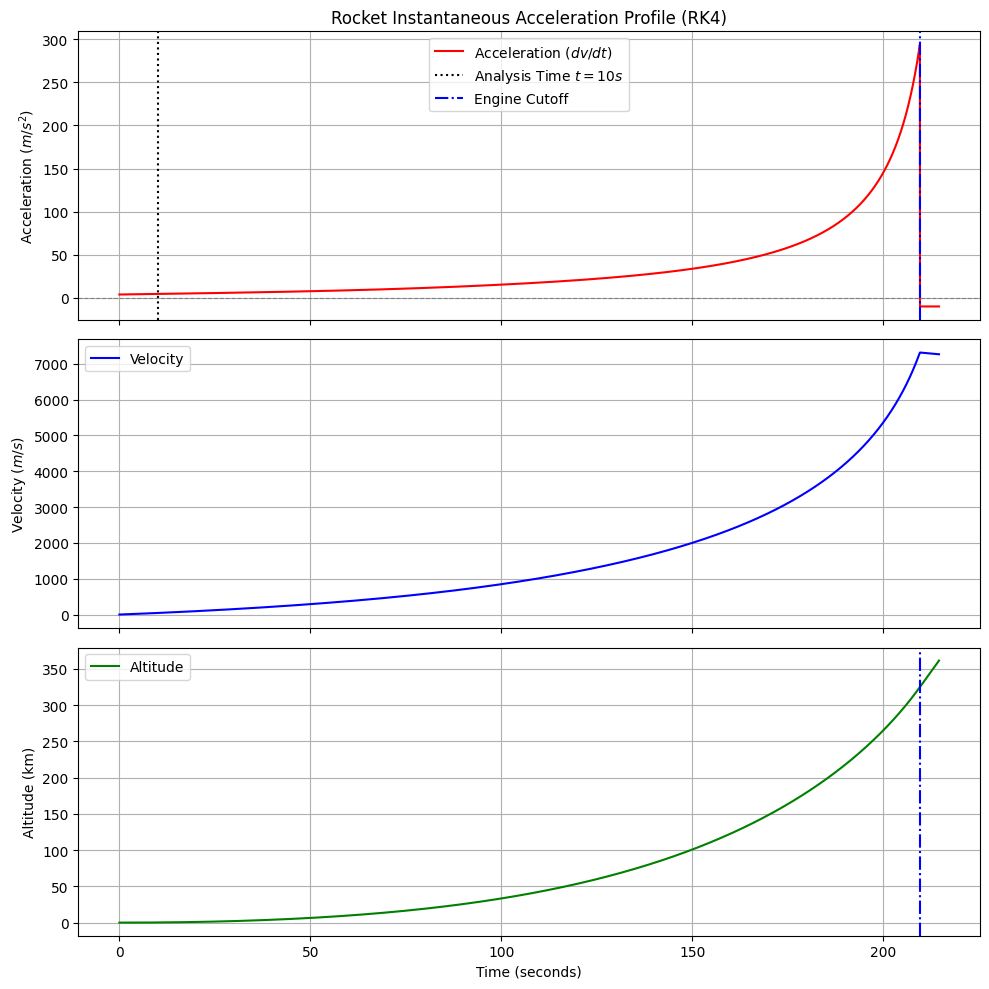

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# 0. FUNDAMENTAL CONSTANTS AND ATMOSPHERIC MODEL
# =============================================================================

class Constants:
    """Defines fundamental constants and units used in the simulation."""
    G = 9.80665              # Standard acceleration due to gravity (m/s^2)

    # Atmospheric Model Parameters (Simplified Exponential Model)
    RHO_0 = 1.225            # Sea-level air density (kg/m^3)
    H_SCALE = 8500.0         # Scale height (meters), density decreases by factor e every H_SCALE meters

def get_air_density(h):
    """Calculates air density rho(h) using a simplified exponential model."""
    if h < 0:
        return Constants.RHO_0
    return Constants.RHO_0 * np.exp(-h / Constants.H_SCALE)

# =============================================================================
# 1. ROCKET PHYSICS MODEL
# =============================================================================

class RocketModel:
    """
    Core physics engine. Calculates forces and instantaneous acceleration (dv/dt)
    at any given state (t, h, v).
    """
    def __init__(self):
        # --- Rocket Initial Parameters (Units: SI - kg, m, s, N) ---
        self.initial_mass = 549000.0  # Initial mass (kg)
        self.struct_mass = 25000.0    # Mass of the rocket structure (kg)
        self.thrust = 7600000.0       # Engine thrust (Newtons)
        self.burn_rate = 2500.0       # Mass flow rate (kg/s)
        self.CdA = 0.5 * 10.0         # Drag Coefficient * Reference Area (m^2)

        # Time when fuel runs out
        self.engine_on_time = (self.initial_mass - self.struct_mass) / self.burn_rate

    def get_mass(self, t):
        """Calculates the instantaneous mass m(t)."""
        if t < 0:
            return self.initial_mass
        if t >= self.engine_on_time:
            return self.struct_mass

        return self.initial_mass - (self.burn_rate * t)

    def get_thrust_force(self, t):
        """Thrust is a constant force while the engine is running."""
        return self.thrust if t < self.engine_on_time else 0.0

    def get_drag_force(self, h, v):
        """Calculates the instantaneous air drag force (F_D) based on altitude (h)."""
        rho = get_air_density(h)
        # F_drag = 0.5 * rho * v^2 * C_d * A
        return 0.5 * rho * v**2 * self.CdA

    def get_instantaneous_acceleration(self, t, h, v):
        """
        Calculates the instantaneous acceleration (a = dv/dt) from Newton's Second Law.
        This is the core differential equation solved by the integrator.
        """
        mass = self.get_mass(t)
        thrust = self.get_thrust_force(t)
        drag = self.get_drag_force(h, v)
        gravity = mass * Constants.G

        # F_net = Thrust - Gravity - Drag (Drag opposes motion)
        F_net = thrust - gravity - drag

        a_instantaneous = F_net / mass

        return a_instantaneous

    def calculate_mission_metrics(self):
        """Calculates key aerospace metrics."""
        T = self.thrust
        m0 = self.initial_mass

        # 1. Initial Thrust-to-Weight Ratio (T/W)
        T_W_ratio = T / (m0 * Constants.G)

        # 2. Specific Impulse (Isp) - measures engine efficiency
        # Isp = Thrust / (mass_flow_rate * g)
        I_sp = T / (self.burn_rate * Constants.G)

        return {
            "T/W Ratio": T_W_ratio,
            "Specific Impulse (s)": I_sp
        }

# =============================================================================
# 2. NUMERICAL INTEGRATION (HIGH-FIDELITY RK4)
# =============================================================================

def integrate_rk4(model, t, h, v, dt):
    """
    Performs one step of Runge-Kutta 4th Order (RK4) integration.
    Solves the system: dh/dt = v; dv/dt = a(t, h, v)
    """
    # System state: Y = [h, v]

    # f(Y) = [dh/dt, dv/dt] = [v, a]
    def f(t_k, h_k, v_k):
        # dh/dt = v
        dh_dt = v_k
        # dv/dt = a
        dv_dt = model.get_instantaneous_acceleration(t_k, h_k, v_k)
        return np.array([dh_dt, dv_dt])

    # K1
    k1 = dt * f(t, h, v)

    # K2
    h2 = h + k1[0] / 2
    v2 = v + k1[1] / 2
    k2 = dt * f(t + dt/2, h2, v2)

    # K3
    h3 = h + k2[0] / 2
    v3 = v + k2[1] / 2
    k3 = dt * f(t + dt/2, h3, v3)

    # K4
    h4 = h + k3[0]
    v4 = v + k3[1]
    k4 = dt * f(t + dt, h4, v4)

    # Final update: Y_new = Y_old + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
    delta_Y = (k1 + 2*k2 + 2*k3 + k4) / 6.0

    h_new = h + delta_Y[0]
    v_new = v + delta_Y[1]

    return h_new, v_new

def simulate_motion_rk4(model, total_time, dt=0.01):
    """
    Runs the full simulation using the high-fidelity RK4 integrator.
    """
    times = np.arange(0, total_time + dt, dt)
    history = {
        't': [], 'v': [], 'h': [], 'a_inst': []
    }

    # Initial conditions
    v = 0.0  # Initial velocity
    h = 0.0  # Initial height

    for t in times:
        a_inst = model.get_instantaneous_acceleration(t, h, v)

        # Record state before the step
        history['t'].append(t)
        history['v'].append(v)
        history['h'].append(h)
        history['a_inst'].append(a_inst)

        # RK4 Integration step
        h, v = integrate_rk4(model, t, h, v, dt)

        # Stop if velocity becomes negative (after engine cut-off) or hits ground
        if v < 0 and h <= 0:
             break
        if t >= model.engine_on_time and v < 0:
             # Stop simulation when engine is off and rocket begins falling back
             break

    return history

# =============================================================================
# 3. ANALYSIS: DEMONSTRATING THE LIMIT (a = lim Δt→0 Δv/Δt)
# =============================================================================

def analyze_acceleration(model, history, analysis_time=10.0):
    """
    Explicitly demonstrates the limit definition by comparing instantaneous
    acceleration with average acceleration over decreasing time windows (Δt).
    """
    # 1. Find the index corresponding to the analysis time (t=10.0s)
    time_array = np.array(history['t'])
    index_t = np.argmin(np.abs(time_array - analysis_time))

    t0 = history['t'][index_t]
    v0 = history['v'][index_t]
    h0 = history['h'][index_t]

    # Calculate the true instantaneous acceleration at t0 (the target value)
    a_true = model.get_instantaneous_acceleration(t0, h0, v0)

    print("-" * 70)
    print("--- 3. CALCULUS CONVERGENCE ANALYSIS ---")
    print(f"ANALYSIS AT TIME t₀ = {t0:.3f} s (Altitude: {h0/1000:.2f} km)")
    print(f"TRUE INSTANTANEOUS ACCELERATION (dv/dt): {a_true:.4f} m/s²")
    print("-" * 70)

    results = []
    # Test different time steps Δt (making Δt smaller simulates the limit)
    delta_t_tests = [0.5, 0.1, 0.05, 0.01, 0.005]

    for delta_t in delta_t_tests:
        # Find the state at t_final = t0 + delta_t
        t_final = t0 + delta_t

        # We need to find the velocity v_final corresponding to t_final
        index_final = np.argmin(np.abs(time_array - t_final))
        if index_final >= len(history['v']):
            continue # Skip if out of bounds

        v_final = history['v'][index_final]

        # Calculate Average Acceleration: a_avg = Δv / Δt
        delta_v = v_final - v0

        a_avg = delta_v / delta_t
        difference = a_avg - a_true

        results.append({
            "Delta t (s)": f"{delta_t:.3f}",
            "Delta v (m/s)": f"{delta_v:.4f}",
            "Avg. Accel (m/s²)": f"{a_avg:.4f}",
            "Difference": f"{difference:.6f}"
        })

    # Print results table
    print(f"| {'Δt (s)':<12} | {'Δv (m/s)':<12} | {'Avg. Accel (m/s²)' :<20} | {'Difference from True':<20} |")
    print(f"|{'-'*13}|{'-'*14}|{'-'*22}|{'-'*22}|")
    for r in results:
        print(f"| {r['Delta t (s)']:<12} | {r['Delta v (m/s)']:<12} | {r['Avg. Accel (m/s²)'] :<20} | {r['Difference']:<20} |")

    print("\nObservation: As Δt approaches zero, the Average Acceleration (Δv/Δt) converges to the True Instantaneous Acceleration (dv/dt).")

# =============================================================================
# 4. MAIN EXECUTION AND PLOTTING
# =============================================================================

def run_analysis():
    """Initializes the model, runs the simulation, and performs the analysis."""

    # 1. Initialize Model
    rocket = RocketModel()
    total_time = rocket.engine_on_time + 5 # 5 seconds past engine cutoff

    # 2. Calculate Mission Metrics
    metrics = rocket.calculate_mission_metrics()
    print("--- 1. ROCKET PERFORMANCE METRICS (NASA Depth) ---")
    print(f"Engine Burn Time: {rocket.engine_on_time:.2f} seconds")
    print(f"Initial Thrust-to-Weight Ratio (T/W): {metrics['T/W Ratio']:.2f} (Must be > 1 to lift off)")
    print(f"Specific Impulse ($I_{{sp}}$): {metrics['Specific Impulse (s)']:.1f} seconds (Measure of efficiency)")
    print("-" * 70)

    # 3. Run Simulation (using high-fidelity RK4)
    print("--- 2. RK4 SIMULATION RUNNING ---")
    print(f"Simulating {total_time:.1f} seconds of flight...\n")
    history = simulate_motion_rk4(rocket, total_time, dt=0.01)

    # 4. Analyze the Limit Definition (The core request)
    analyze_acceleration(rocket, history, analysis_time=10.0)

    # 5. Plot Results for Depth
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

    # Plot 1: Instantaneous Acceleration vs. Time
    ax1.plot(history['t'], history['a_inst'], label='Acceleration ($dv/dt$)', color='red')
    ax1.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    ax1.axvline(10.0, color='black', linestyle=':', label='Analysis Time $t=10s$')
    ax1.axvline(rocket.engine_on_time, color='blue', linestyle='-.', label='Engine Cutoff')
    ax1.set_ylabel('Acceleration ($m/s^2$)')
    ax1.set_title('Rocket Instantaneous Acceleration Profile (RK4)')
    ax1.legend()
    ax1.grid(True)

    # Plot 2: Velocity vs. Time
    ax2.plot(history['t'], history['v'], label='Velocity', color='blue')
    ax2.set_ylabel('Velocity ($m/s$)')
    ax2.legend()
    ax2.grid(True)

    # Plot 3: Altitude vs. Time (for drag context)
    ax3.plot(history['t'], [h / 1000 for h in history['h']], label='Altitude', color='green')
    ax3.axvline(rocket.engine_on_time, color='blue', linestyle='-.')
    ax3.set_xlabel('Time (seconds)')
    ax3.set_ylabel('Altitude (km)')
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    run_analysis()
